In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import scipy.optimize as opt    
import array
from scipy.signal import find_peaks, peak_prominences, peak_widths
def unPackRawFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
   
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

Below is the figure 1 we want to reproduce from the cosmological simulation paper, this time we are going to use the new simulation data

In [2]:
#below shows the graph and the peaks
#display_all()

we have that the Lyman-limit systems is at $$1.6 X 10^{17} cm^{-2}	\lesssim N_{HI} \lesssim 10^{20} cm^{-2}$$
Now we are going to convert the units and find the lyman limited systems within the line of sights

In [3]:
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    data = []
    for i in range(1000):
        temp_data = []
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1452*3.086e24 /0.68
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k+1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-1):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(area_under >= (1.6*10**17)and area_under  <= (10**22)):
                        data.append(area_under)
    return data
lyman_limited_value = lyman_identification()


In [4]:
len(lyman_limited_value)

2496

In [5]:
import pickle

In [6]:
with open('a_lyman_limited_value.pkl', 'wb') as f:
    pickle.dump(lyman_limited_value, f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
##the a-axis is the number of lyman-limited series, y-axis is the column density
lyman_limited_value_sorted = sorted(lyman_limited_value)
#below shows the total of lyman_limited_value in the nlos

We got the data now, now is the data processing

We bin the data by distance first, by doing so, we can figure out the change in the number density Vs the column density:

In [8]:
##need to bin the data, and graph it like the paper.
##right here we are goin go bin the data, using panda
##find the max/min

min_value_lyman_limited_value = np.log10(min(lyman_limited_value_sorted))
max_value_lyman_limited_value = np.log10(max(lyman_limited_value_sorted))
print(min_value_lyman_limited_value)
print(max_value_lyman_limited_value)

17.204365238441987
21.957172386762977


In [9]:
##putting data into panda data_frame for better organization
##belows is the bin value
bins = np.linspace(min_value_lyman_limited_value,max_value_lyman_limited_value,51)
bins

array([17.20436524, 17.29942138, 17.39447752, 17.48953367, 17.58458981,
       17.67964595, 17.7747021 , 17.86975824, 17.96481438, 18.05987053,
       18.15492667, 18.24998281, 18.34503895, 18.4400951 , 18.53515124,
       18.63020738, 18.72526353, 18.82031967, 18.91537581, 19.01043195,
       19.1054881 , 19.20054424, 19.29560038, 19.39065653, 19.48571267,
       19.58076881, 19.67582496, 19.7708811 , 19.86593724, 19.96099338,
       20.05604953, 20.15110567, 20.24616181, 20.34121796, 20.4362741 ,
       20.53133024, 20.62638639, 20.72144253, 20.81649867, 20.91155481,
       21.00661096, 21.1016671 , 21.19672324, 21.29177939, 21.38683553,
       21.48189167, 21.57694781, 21.67200396, 21.7670601 , 21.86211624,
       21.95717239])

In [10]:
##divide up the data 
bin_data = pd.DataFrame()
bin_data['cut_lyman_limited'] = np.array(lyman_limited_value_sorted)
bin_data['cut_lyman_limited'] = pd.cut(np.log10(bin_data['cut_lyman_limited']), bins = bins,include_lowest = True).astype(str)

below we visualize the number density vs column density without any normalization

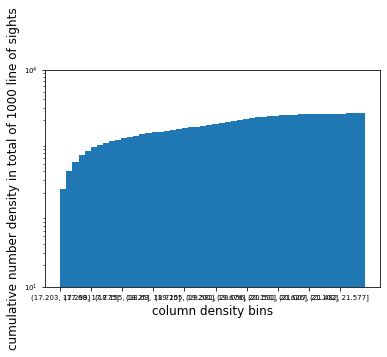

<Figure size 640x480 with 0 Axes>

In [11]:
##graph similar to the paper, culmulative
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
hist = ax.hist(bin_data,bins=50,cumulative =1,log =True)
ax.set_xticks(ax.get_xticks()[::5])
ax.set_yticks(ax.get_yticks()[::3])
ax.set_xlabel('column density bins', fontsize=12)
ax.set_ylabel('cumulative number density in total of 1000 line of sights', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=7)
plt.figure(figsize=(8, 6), dpi=80)
plt.show()

In [12]:
##extract the change in column density counts
##abserve the trend that as the column density decreases the rate of number density decrease increase.
number_count = []
for i in range(1, len(hist[0])):
    number_count.append(hist[0][i]- hist[0][i-1])
total =0 
for i in number_count:
    total += i

number density over distance

In [13]:
# lyman_limited_counts
# distance_value =  np.linspace(0,100,100,endpoint = True)
# fig = plt.figure(figsize=(20, 2))
# ax = fig.add_subplot(111)
# ax.plot(distance_value, lyman_limited_counts)

In [14]:
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# x,y,z =[],[],[]
# for i in range(37394):
#     x.append(lyman_limited_distance[i][0])
#     y.append(lyman_limited_distance[i][1])
#     z.append(lyman_limited_distance[i][2])
# ax.set_xlabel("distance alone los")
# ax.set_ylabel("number count for los")
# ax.set_zlabel("number count(N_hi)")
# ax.scatter3D(y,x,z,cmap='binary',s=0.05)

can I put this into the box

number density varies a lot

We will now reporduce figure one:

In [15]:
#we here find the change in column density
#d_N_column = bins[1] - bins[0]
d_N_column= []
for i in range(1,50):
    d_N_column.append(10**bins[i]-10**bins[i-1])
d_N_column


[3.917019491848816e+16,
 4.875418216070067e+16,
 6.068313632610406e+16,
 7.553081338201818e+16,
 9.401135332708557e+16,
 1.1701362872512422e+17,
 1.4564399748382707e+17,
 1.8127951619120768e+17,
 2.2563417345208474e+17,
 2.8084132889953587e+17,
 3.495563230133064e+17,
 4.350841930472896e+17,
 5.415386379161485e+17,
 6.740398778960573e+17,
 8.389609257473966e+17,
 1.0442341143493432e+18,
 1.2997326241380577e+18,
 1.6177453609637396e+18,
 2.0135680249278044e+18,
 2.506238799285541e+18,
 3.119454044404308e+18,
 3.882708039602784e+18,
 4.832711591901098e+18,
 6.015157743585149e+18,
 7.486919505158754e+18,
 9.318785319720886e+18,
 1.1598863828469064e+19,
 1.4436821698924167e+19,
 1.7969158345921634e+19,
 2.2365771247618572e+19,
 2.78381276335258e+19,
 3.464943558443075e+19,
 4.3127303751337345e+19,
 5.367949859754734e+19,
 6.681355705188588e+19,
 8.316119789780546e+19,
 1.035087060314321e+20,
 1.2883475100331272e+20,
 1.603574588310133e+20,
 1.995930011311782e+20,
 2.484285195772005e+20,
 3

In [16]:
def aH_calc(aexp,OmegaM):
    aH = 100*aexp*np.sqrt(OmegaM/aexp**3+(1-OmegaM))
    return aH
aH = aH_calc(aexp=0.1433,OmegaM=0.3036)
print(aH)

146.04563456166113


In [17]:
#dN / (dz *dN_HI)
y_value = []
#dz = dv/c = H*dr/c = H*a*dx/c
#dx = 200cMpc * number of line of sights
dz =(200*1000)
for i,k in zip(number_count,d_N_column):
    if(number_count == 0):
        y_value.append(0)
    y_value.append(i/(dz*(k)))
print(dz)

200000


In [18]:
x_value = []
for i in range(1,50):
    x_value.append(bins[i])

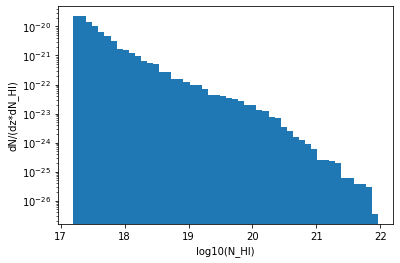

In [19]:
plt.bar(x_value,y_value,width = 0.2)
plt.xlabel("log10(N_HI)")
plt.ylabel("dN/(dz*dN_HI)")
plt.yscale('log')


In [20]:

lyman_limited_value_sorted = list(reversed(lyman_limited_value_sorted))

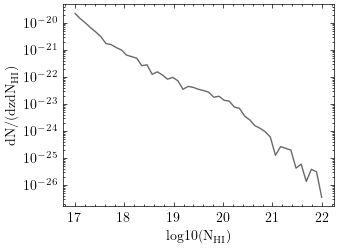

In [21]:
import matplotlib.pyplot as plt

x_axis = np.linspace(17,22,49)
with open('y_value_80_non_uniform.pkl', 'wb') as f:
    pickle.dump(y_value, f, protocol=pickle.HIGHEST_PROTOCOL)
with plt.style.context('science','notebook'):
    plt.figure()    
    plt.plot(x_axis,y_value,color = "dimgray")
    plt.rcParams['font.size'] = 8
    plt.yscale("log") 
    plt.yticks()
    plt.xlabel("$\mathrm{log10(N_{HI})}$",fontsize = 10)
    plt.ylabel("$\mathrm{dN/(dzdN_{HI})}$",fontsize =10,)
    plt.show()

In [22]:
len(bins)

51

In [23]:
range_bins =[]
for i in range(1,50):
    range_bins.append(bins[i])
len(range_bins)

49

In [26]:
y_axis = (np.multiply(np.power(10,x_axis),y_value))

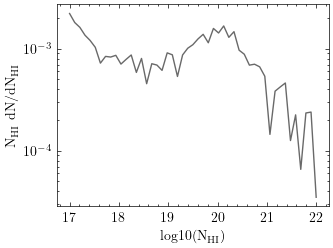

In [27]:
import matplotlib.pyplot as plt

x_axis = np.linspace(17,22,49)
with plt.style.context('science','notebook'):
    plt.figure()    
    plt.plot(x_axis,y_axis,color = "dimgray")
    plt.rcParams['font.size'] = 8
    plt.yscale("log") 
    plt.yticks()
    plt.xlabel("$\mathrm{log10(N_{HI})}$",fontsize = 10)
    plt.ylabel("$\mathrm{N_{HI}}$ $\mathrm{dN/dN_{HI}}$",fontsize =10,)
    plt.savefig('figure_one_part_two.pdf') 
    plt.show()

tried to increase the peak prominence, results with curves. Paper has 10000 line of sights, shouldnt change anything

make it a line